In [1]:
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline, FeatureUnion
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

In [7]:
# Standard plotly imports
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

# Load dataset

In [8]:
df = pd.read_csv("./Predictive_Data/train_file.csv")
df_test = pd.read_csv("./Predictive_Data/test_file.csv")

In [9]:
df.shape, df_test.shape

((31653, 12), (21102, 11))

In [10]:
df.head()

,ID,UsageClass,CheckoutType,CheckoutYear,CheckoutMonth,Checkouts,Title,Creator,Subjects,Publisher,PublicationYear,MaterialType
0,1,Physical,Horizon,2005,4,1,Tidal wave,NaN,"Tsunamis, Tsunamis Juvenile literature",NaN,NaN,BOOK
1,2,Physical,Horizon,2005,4,1,London holiday / Richard Peck.,"Peck, Richard, 1934-",NaN,"Viking,",1998.,BOOK
2,3,Physical,Horizon,2005,4,3,Cinco de Mayo : celebrating Hispanic pride / C...,"Gnojewski, Carol",Cinco de Mayo Mexican holiday History Juvenile...,"Enslow Publishers,",c2002.,BOOK
3,4,Physical,Horizon,2005,4,1,Annapolis,NaN,"War stories, Historical fiction, Domestic fict...",NaN,NaN,BOOK
4,5,Physical,Horizon,2005,4,1,As a man thinketh,NaN,Thought and thinking,NaN,NaN,BOOK


# Lets understand the data

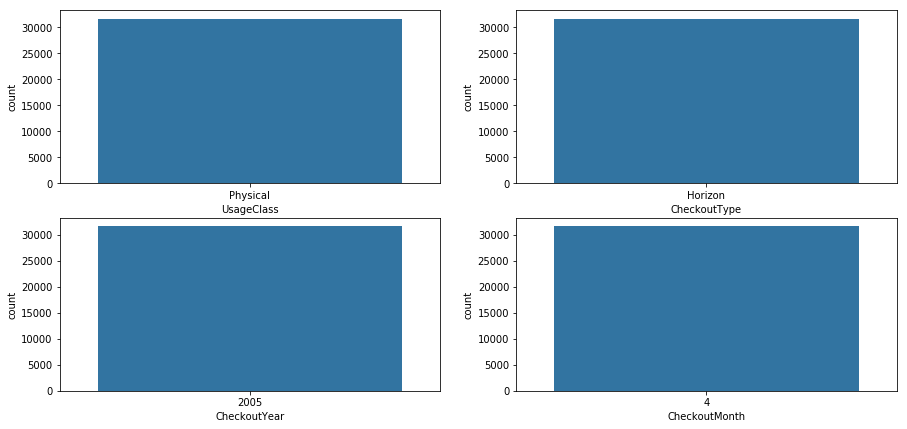

In [11]:

plt.figure(figsize=(15,7))
plt.subplot(2,2,1)
sns.countplot(x='UsageClass', data=df);

plt.subplot(2,2,2)
sns.countplot(x='CheckoutType', data=df);

plt.subplot(2,2,3)
sns.countplot(x='CheckoutYear', data=df);

plt.subplot(2,2,4)
sns.countplot(x='CheckoutMonth', data=df);



In [20]:
def categorical_feature_distribution(feature_name, target_name, top_counts=None):
    material_trace = []

    for material in df[target_name].unique():
        if not top_counts:
            _tmp_material = df[df[target_name]==material][feature_name].value_counts()
        else:
            _tmp_material = df[df[target_name]==material][feature_name].value_counts()[:top_counts]
            
        tmp_trace = go.Bar(
            x=_tmp_material.index,
            y=_tmp_material.values,
            name=material
        )
        material_trace.append(tmp_trace)

    layout = go.Layout(
        barmode='group',
        title=feature_name + " VS " + target_name + " - Distribution ",
        yaxis=dict(
            title='Counts',
        ),
        xaxis=dict(
            title=feature_name,
        )
        
    )

    fig = go.Figure(data=material_trace, layout=layout)
    iplot(fig) #, filename='grouped-bar')
    
    


In [21]:
df['MaterialType'].iplot(kind='hist', xTitle='MaterialType',
                  yTitle='count', title='Target Distribution')

In [22]:
categorical_feature_distribution('Checkouts','MaterialType')

In [23]:
categorical_feature_distribution('Creator','MaterialType', 20)

In [24]:
categorical_feature_distribution('Publisher','MaterialType', 20)

In [25]:
categorical_feature_distribution('Subjects','MaterialType', 20)

In [26]:
def create_wordcloud(material):
    text = " ".join(review for review in df[df['MaterialType'] == material].Title)
    print ("There are {} words in the combination of all review.".format(len(text)))

    # Create the wordcloud object
    wordcloud = WordCloud(width=1024, height=480, margin=0).generate(text)

    # Display the generated image:
    plt.figure(figsize=(15,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

There are 1095796 words in the combination of all review.


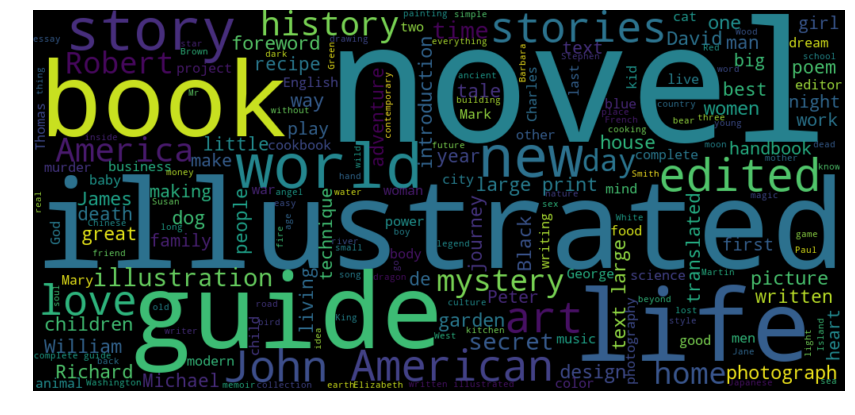

In [24]:
create_wordcloud('BOOK')

There are 138709 words in the combination of all review.


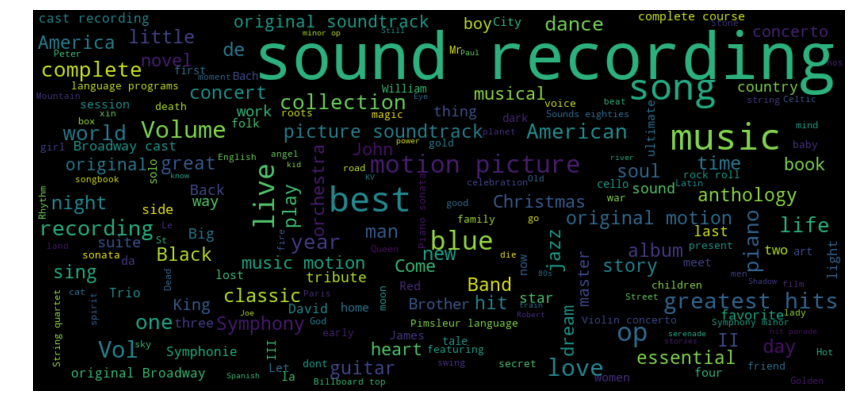

In [25]:
create_wordcloud('SOUNDDISC')

There are 99976 words in the combination of all review.


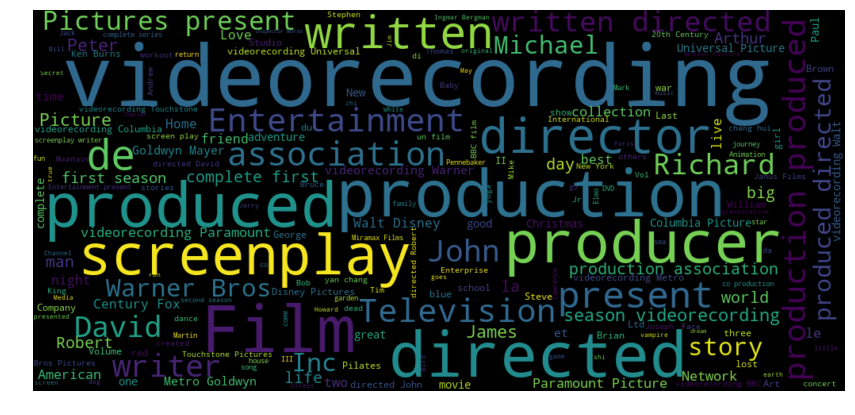

In [26]:
create_wordcloud('VIDEODISC')

# Handle missing values

In [27]:
(df.isnull().sum() / df.shape[0]) * 100

ID                  0.000000
UsageClass          0.000000
CheckoutType        0.000000
CheckoutYear        0.000000
CheckoutMonth       0.000000
Checkouts           0.000000
Title               0.000000
Creator            73.095757
Subjects            5.569772
Publisher          69.238303
PublicationYear    69.285692
MaterialType        0.000000
dtype: float64

In [28]:
(df_test.isnull().sum() / df_test.shape[0]) * 100

ID                  0.000000
UsageClass          0.000000
CheckoutType        0.000000
CheckoutYear        0.000000
CheckoutMonth       0.000000
Checkouts           0.000000
Title               0.000000
Creator            71.576154
Subjects            5.748270
Publisher          67.420150
PublicationYear    67.491233
dtype: float64

In [29]:
df['Publisher'].fillna("nopublisher", inplace=True)
df_test['Publisher'].fillna("nopublisher", inplace=True)

df['Creator'].fillna("nocreator", inplace=True)
df_test['Creator'].fillna("nocreator", inplace=True)

df['Subjects'].fillna("nosubject", inplace=True)
df_test['Subjects'].fillna("nosubject", inplace=True)



# PIPELINE 

![Pipeline](https://github.com/asingleneuron/Ericsson-Machine-Learning-Challenge/blob/master/images/PIPELINE.jpg?raw=True)

> **Create new feature "INFO"  by concatenating Title, Subjects , Publisher, Creator** 

In [30]:
df['info'] = df['Title'] + " " + df['Subjects'] + " " + df['Publisher'] + " " + df['Creator']
df_test['info'] = df_test['Title'] + " " + df_test['Subjects'] + " " + df_test['Publisher'] + " " + df_test['Creator']


> **Numerical encode categorical features**

In [31]:
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(df['MaterialType'])

categorical_features = ['Checkouts', 'Creator', 'Subjects', 'Publisher']

for col in categorical_features:
    print(col)
    le = LabelEncoder()
    le.fit(list(df[col]) + list(df_test[col]))
    df[col] = le.transform(df[col])
    df_test[col] = le.transform(df_test[col])


Checkouts
Creator
Subjects
Publisher


> **Add some functions and Transformer class**

In [32]:
stop_words = set(stopwords.words('english'))

In [33]:
def tokenize(text):
    '''
        Input: text
        Returns: clean tokens
        Desc:
            Generates a clean token of text (words) by first getting words from the text.
            Applies Lemmatization on the words.
            Normalize the text by lowering it and removes the extra spaces.
    '''
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        #
        if tok not in string.punctuation:# and tok not in stop_words:
            clean_tok = tok.lower().strip()
            #clean_tok = lemmatizer.lemmatize(tok).lower().strip()
            clean_tokens.append(clean_tok)

    return clean_tokens

In [34]:
class TextLengthExtractor(BaseEstimator, TransformerMixin):
    '''
        Input: X
        return: pandas series of length of text
        TextLengthExtractor is a transformer , can be used in pipeline to extract the length of the text from a given input.
        Input can be an array of text or pandas Series.
    '''

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.Series(X).apply(lambda x: len(x)).values.reshape(-1,1)


    
class WordCountExtractor(BaseEstimator, TransformerMixin):
    '''
        Input: X
        return: pandas series of word count
        WordCountExtractor is a transformer , can be used in pipeline to extract the number of words of the text from a given input.
        Input can be an array of text or pandas Series.
    '''
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.Series(X).apply(lambda x: len(x.split())).values.reshape(-1,1)
    
    
    
class MessageExtractor(BaseEstimator, TransformerMixin):        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X["info"]
    
class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor     
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ [ 'Checkouts','Creator','Publisher','Subjects'] ] 

# Pipeline for Feature Engineering

In [35]:
pipeline = Pipeline([
        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('text', MessageExtractor()),
                ('tfidf', TfidfVectorizer(tokenizer=tokenize,
                                         ngram_range=(1,2),
                                         max_df=0.5,
                                         max_features=5000,
                                         use_idf=False)),
            ])),
            
            ('categorical_features', Pipeline([
                ('cat_features', FeatureSelector()),
                
            ])),
            
            ('text_length_pipeline', Pipeline([
                ('text', MessageExtractor()),
                ('text_len', TextLengthExtractor()),
                
            ])),

            ('word_count_pipeline', Pipeline([
                ('text', MessageExtractor()),
                ('word_count', WordCountExtractor()),                
            ])),

        ])),
        
]) 

In [36]:
pipeline.fit(df)

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text_pipeline', Pipeline(memory=None,
     steps=[('text', MessageExtractor()), ('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features...line(memory=None,
     steps=[('text', MessageExtractor()), ('word_count', WordCountExtractor())]))],
       transformer_weights=None))])

In [37]:
XTest_trans = pipeline.transform(df_test)
dxtest = xgb.DMatrix(XTest_trans)

In [38]:
XTest_trans.todense()

matrix([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.10070000e+04, 8.60000000e+01, 1.20000000e+01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.75820000e+04, 1.10000000e+02, 1.50000000e+01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.82850000e+04, 1.15000000e+02, 1.60000000e+01],
        ...,
        [0.00000000e+00, 2.39045722e-01, 0.00000000e+00, ...,
         2.20420000e+04, 1.94000000e+02, 2.60000000e+01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.69750000e+04, 9.60000000e+01, 1.20000000e+01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         8.51600000e+03, 1.10000000e+02, 1.60000000e+01]])

# XGB parameters

In [39]:
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softprob'
param['eta'] = 0.1
param['max_depth'] = 6
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 8
param['eval_metric'] = ['mlogloss']
param['seed'] = 1

# OOF = Out Of fold (predictions)

![OOF](https://github.com/asingleneuron/Ericsson-Machine-Learning-Challenge/blob/master/images/OOF_PREDICTION.png?raw=True)

In [40]:
num_splits = 5
skf = StratifiedKFold(n_splits= num_splits, random_state=1, shuffle=True)

In [41]:
y_test_pred = np.zeros((df_test.shape[0], 8))
print(y_test_pred.shape)
y_valid_scores = []

X = df
fold_cnt = 1
for train_index, test_index in skf.split(X, y):
    print("FOLD .... ",fold_cnt)
    fold_cnt += 1
    
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    
    X_train_trans = pipeline.transform(X_train)
    dtrain = xgb.DMatrix(X_train_trans, label=y_train)

    X_valid_trans = pipeline.transform(X_valid)
    dvalid = xgb.DMatrix(X_valid_trans, label=y_valid)
    
    evallist = [(dtrain, 'train'), (dvalid, 'eval')]
    
    num_round = 10000
    bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10, verbose_eval=50)
    
    #Predict validation data
    y_pred_valid = bst.predict(dvalid, ntree_limit=bst.best_ntree_limit)
    y_valid_scores.append(f1_score(y_valid, np.argmax(y_pred_valid, axis=1), average='weighted'))
    
    #Predict test data
    y_pred = bst.predict(dxtest, ntree_limit=bst.best_ntree_limit)
    
    y_test_pred += y_pred

(21102, 8)
FOLD ....  1
[0]	train-mlogloss:1.78257	eval-mlogloss:1.78364
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[50]	train-mlogloss:0.315595	eval-mlogloss:0.363372
[100]	train-mlogloss:0.255633	eval-mlogloss:0.331972
[150]	train-mlogloss:0.228496	eval-mlogloss:0.324661
[200]	train-mlogloss:0.208996	eval-mlogloss:0.32163
[250]	train-mlogloss:0.19375	eval-mlogloss:0.320327
[300]	train-mlogloss:0.181133	eval-mlogloss:0.319586
Stopping. Best iteration:
[303]	train-mlogloss:0.180393	eval-mlogloss:0.319533

FOLD ....  2
[0]	train-mlogloss:1.78201	eval-mlogloss:1.78483
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[50]	train-mlogloss:0.31623	eval-mlogloss:0.366995
[100]	train-mlogloss:0.258394	eval-mlogloss:0.334731
[150]	train-mlogloss:0.231938	eval-mlogloss:0.327335
[200]	train

In [42]:
y_test_pred /= num_splits

In [43]:
y_valid_scores

[0.8814103373715003,
 0.8878344997333046,
 0.8835592353761934,
 0.8775448550875664,
 0.8809004460551831]

In [44]:
np.mean(y_valid_scores)

0.8822498747247497

# Prepare the output

In [45]:
pred_material = np.argmax(y_test_pred, axis=1)
output = df_test[['ID']].copy()
output['MaterialType'] = target_encoder.inverse_transform(pred_material)

/home/shobhit/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



In [46]:
output.head()

,ID,MaterialType
0,31654,BOOK
1,31655,VIDEOCASS
2,31656,SOUNDDISC
3,31657,BOOK
4,31658,VIDEOCASS


In [47]:
output.to_csv("./predict_material_submission.csv", index=False)